<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !pip install ./deepul

# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import deepul.utils as deepul_utils
import warnings

warnings.filterwarnings("ignore")

In [5]:
ptu.set_gpu_mode(True)

# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

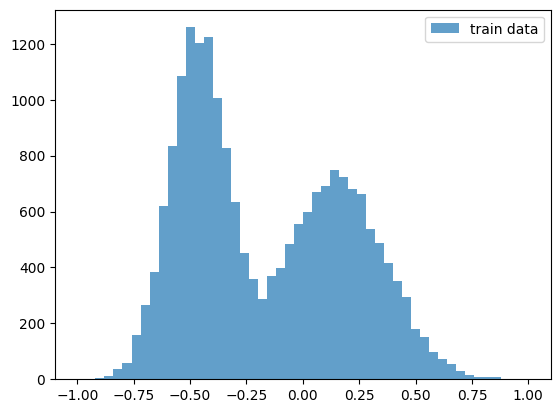

In [8]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

### Solution

In [12]:
def train(
    generator,
    critic,
    c_loss_fn,
    g_loss_fn,
    train_loader,
    g_optimizer,
    c_optimizer,
    n_critic=1,
    g_scheduler=None,
    c_scheduler=None,
    weight_clipping=None,
):
    """
    generator:
    critic: discriminator in 1ab, general model otherwise
    loss_fn
    train_loader: instance of DataLoader class
    optimizer:
    ncritic: how many critic gradient steps to do for every generator step
    """
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        x = x.to(ptu.device).float()
        c_optimizer.zero_grad()
        c_loss = c_loss_fn(generator, critic, x)
        c_loss.backward()
        c_optimizer.step()
        c_losses.append(c_loss.item())
        if weight_clipping is not None:
            for param in critic.parameters():
                param.data.clamp_(-weight_clipping, weight_clipping)

        if i % n_critic == 0:  # generator step
            g_optimizer.zero_grad()
            g_loss = g_loss_fn(generator, critic, x)
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)


def train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args["epochs"], train_args["lr"]
    if "optim_cls" in train_args:
        g_optimizer = train_args["optim_cls"](generator.parameters(), lr=lr)
        c_optimizer = train_args["optim_cls"](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

    if train_args.get("lr_schedule", None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(
            g_optimizer, train_args["lr_schedule"]
        )
        c_scheduler = optim.lr_scheduler.LambdaLR(
            c_optimizer, train_args["lr_schedule"]
        )
    else:
        g_scheduler = None
        c_scheduler = None

    train_losses = dict()
    for epoch in tqdm_notebook(range(epochs), desc="Epoch", leave=False):
        if epoch == 1:
            epoch1_snapshot = get_training_snapshot(generator, critic)
        generator.train()
        critic.train()
        train_loss = train(
            generator,
            critic,
            c_loss_fn,
            g_loss_fn,
            train_loader,
            g_optimizer,
            c_optimizer,
            n_critic=train_args.get("n_critic", 0),
            g_scheduler=g_scheduler,
            c_scheduler=c_scheduler,
            weight_clipping=train_args.get("weight_clipping", None),
        )

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get("q1", False):  # q1, return the snapshots
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *epoch1_snapshot, *final_snapshot]
    else:
        return train_losses


def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-1, 1, 1000)
    samples = ptu.get_numpy(generator.sample(n_samples))
    critic_output = ptu.get_numpy(critic(ptu.FloatTensor(xs).unsqueeze(1)))
    return samples, xs, critic_output

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)

    def forward(self, z):
        return torch.tanh(self.mlp(z))

    def sample(self, n):
        # n is the number of samples to return
        z = ptu.normal(ptu.zeros(n, self.latent_dim), ptu.ones(n, self.latent_dim))
        return self.forward(z)


class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)

    def forward(self, z):
        return torch.sigmoid(self.mlp(z))

In [14]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return (1 - critic(fake_data)).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return -(1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = (
        train_epochs(
            g,
            c,
            g_loss,
            c_loss,
            train_loader,
            dict(epochs=25, lr=1e-4, n_critic=2, q1=True),
        )
    )

    return (
        train_losses["c_losses"],
        samples_1,
        xs_1,
        critic_1,
        samples_final,
        xs_final,
        critic_final,
    )

### Results

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

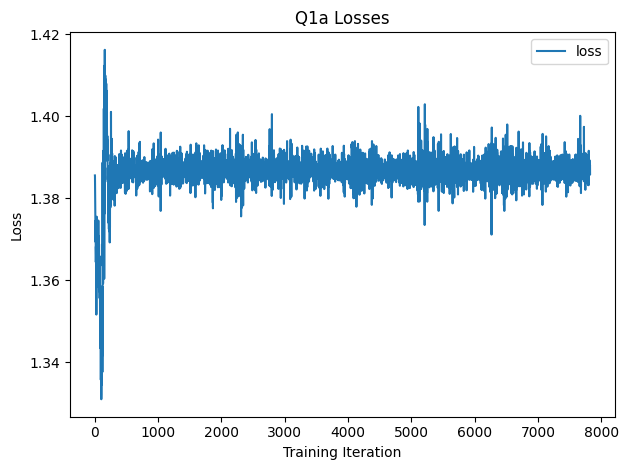

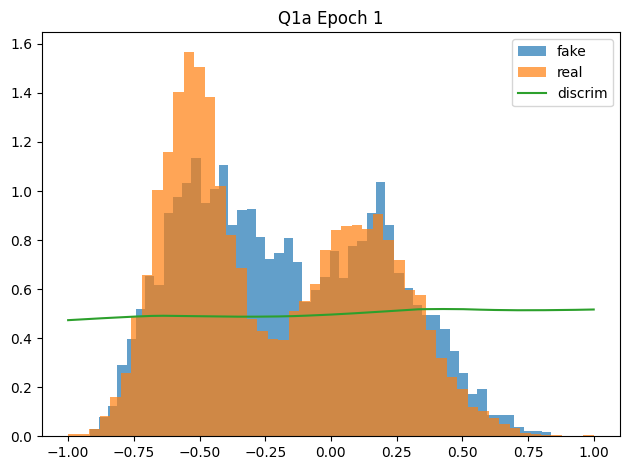

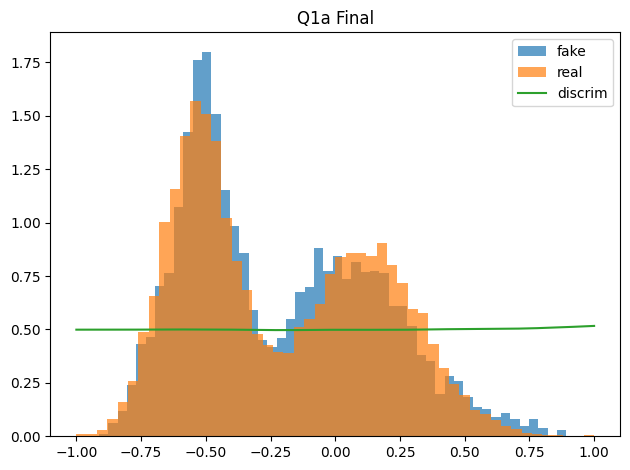

In [15]:
q1_save_results("a", q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [18]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """
    # create data loaders
    loader_args = dict(batch_size=128, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return -critic(fake_data).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return -(1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = (
        train_epochs(
            g,
            c,
            g_loss,
            c_loss,
            train_loader,
            dict(epochs=40, lr=1e-4, n_critic=2, q1=True),
        )
    )

    return (
        train_losses["c_losses"],
        samples_1,
        xs_1,
        critic_1,
        samples_final,
        xs_final,
        critic_final,
    )

 ### Results

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

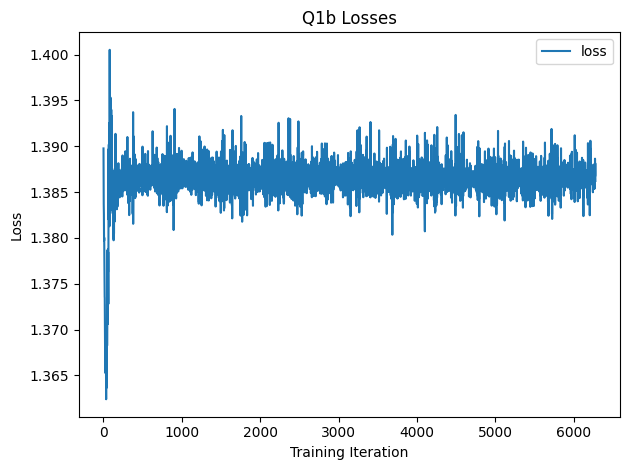

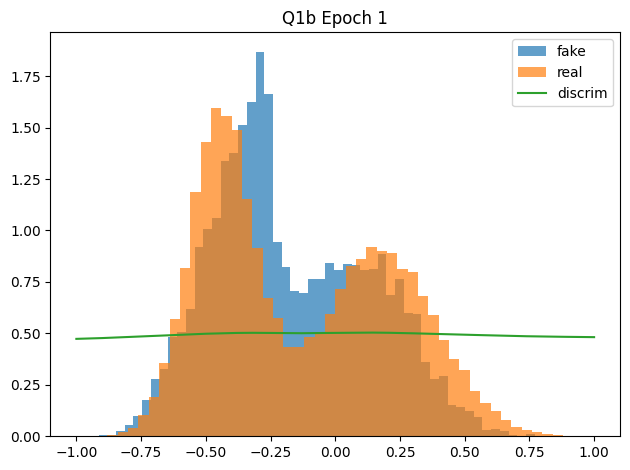

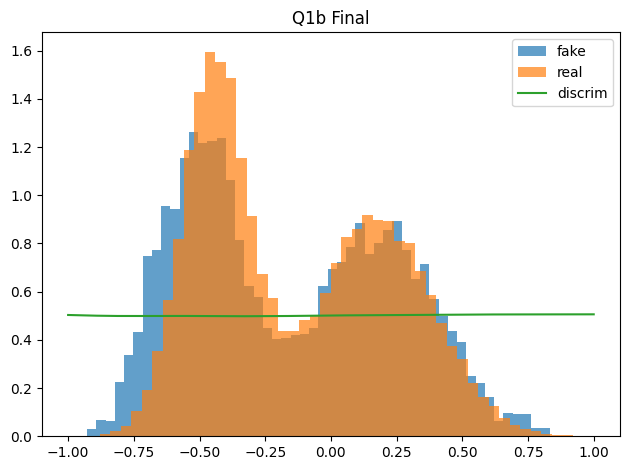

In [19]:
q1_save_results("b", q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train a GAN on CIFAR-10. Execute the cell below to visualize the dataset. 

100%|██████████| 170498071/170498071 [00:04<00:00, 35357359.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


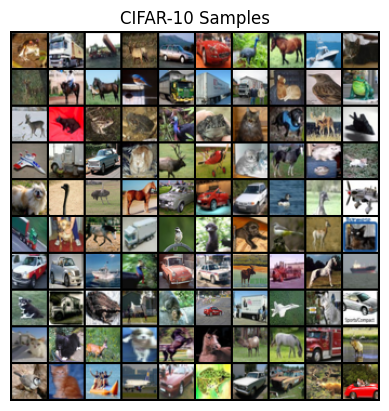

In [20]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf) (see page 17), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
The discriminator (no BatchNorm!).
```
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
```


**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

 ### Models

In [6]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = (
            torch.stack(stack, 0)
            .transpose(0, 1)
            .permute(0, 2, 1, 3, 4)
            .reshape(batch_size, s_height, s_width, s_depth)
        )
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class Upsample_Conv2d(nn.Module):
    def __init__(
        self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True
    ):
        super(Upsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(
            in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias
        )
        self.depth_to_space = DepthToSpace(2)

    def forward(self, x):
        _x = torch.cat([x, x, x, x], dim=1)
        _x = self.depth_to_space(_x)
        _x = self.conv(_x)
        return _x


class Downsample_Conv2d(nn.Module):
    def __init__(
        self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True
    ):
        super(Downsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(
            in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias
        )
        self.space_to_depth = SpaceToDepth(2)

    def forward(self, x):
        _x = self.space_to_depth(x)
        _x = sum(_x.chunk(4, dim=1)) / 4.0
        _x = self.conv(_x)
        return _x


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlockUp, self).__init__()
        self.layers = nn.ModuleList(
            [
                nn.BatchNorm2d(in_dim),
                nn.ReLU(),
                nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                nn.BatchNorm2d(n_filters),
                nn.ReLU(),
                Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1),
                Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0),
            ]
        )

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), stride=1, n_filters=256):
        super(ResnetBlockDown, self).__init__()
        self.layers = nn.ModuleList(
            [
                nn.ReLU(),
                nn.Conv2d(in_dim, n_filters, kernel_size, stride=stride, padding=1),
                nn.ReLU(),
                Downsample_Conv2d(n_filters, n_filters, kernel_size),
                Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0),
            ]
        )

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResBlock(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResBlock, self).__init__()
        self.layers = nn.ModuleList(
            [
                nn.ReLU(),
                nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                nn.ReLU(),
                nn.Conv2d(n_filters, n_filters, kernel_size, padding=1),
            ]
        )

    def forward(self, x):
        _x = x
        for op in self.layers:
            _x = op(_x)
        return x + _x


class Generator(nn.Module):
    def __init__(self, n_filters=256):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh(),
        ]
        self.net = nn.Sequential(*network)
        self.noise = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

    def forward(self, z):
        z = self.fc(z).reshape(-1, 256, 4, 4)
        return self.net(z)

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).to(ptu.device)
        return self.forward(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockDown(3, n_filters=128),
            ResnetBlockDown(128, n_filters=128),
            ResBlock(128, n_filters=128),
            ResBlock(128, n_filters=128),
            nn.ReLU(),
        ]
        self.net = nn.Sequential(*network)
        self.fc = nn.Linear(128, 1)

    def forward(self, z):
        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return self.fc(z)

In [13]:
class Solver(object):
    def __init__(self, train_data, n_iterations=50000, batch_size=256, n_filters=128):
        self.n_critic = 5
        self.log_interval = 100
        self.batch_size = batch_size
        self.n_filters = n_filters
        self.train_loader = self.create_loaders(train_data)
        self.n_batches_in_epoch = len(self.train_loader)
        # Number of epochs to train in order to have n_iterations of the
        # generator, meaning that do a gradient update for the generator
        # n_iterations times.
        self.n_epochs = self.n_critic * n_iterations // self.n_batches_in_epoch
        self.n_iterations = n_iterations
        self.curr_itr = 0

    def build(self, part_name):
        self.g = Generator(n_filters=self.n_filters).to(ptu.device)
        self.d = Discriminator().to(ptu.device)
        self.g_optimizer = torch.optim.Adam(
            self.g.parameters(), lr=2e-4, betas=(0, 0.9)
        )
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.g_optimizer,
            lambda iter: (self.n_iterations - iter) / self.n_iterations,
            last_epoch=-1,
        )
        self.d_optimizer = torch.optim.Adam(
            self.d.parameters(), lr=2e-4, betas=(0, 0.9)
        )
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.d_optimizer,
            lambda iter: (self.n_iterations - iter) / self.n_iterations,
            last_epoch=-1,
        )
        self.part_name = part_name

    def create_loaders(self, train_data):
        train_loader = data.DataLoader(
            train_data, batch_size=self.batch_size, shuffle=True
        )
        return train_loader

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.shape[0]

        # Calculate interpolation
        eps = torch.rand(batch_size, 1, 1, 1).to(ptu.device)
        eps = eps.expand_as(real_data)
        interpolated = eps * real_data.data + (1 - eps) * fake_data.data
        interpolated.requires_grad = True

        d_output = self.d(interpolated)
        gradients = torch.autograd.grad(
            outputs=d_output,
            inputs=interpolated,
            grad_outputs=torch.ones(d_output.size()).to(ptu.device),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.reshape(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)
        return ((gradients_norm - 1) ** 2).mean()

    def train(self, verbose=False):
        train_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc="Epoch", leave=False):
            # epoch_i += 1

            self.d.train()
            self.g.train()
            self.batch_loss_history = []

            for batch_i, x in enumerate(
                tqdm_notebook(self.train_loader, desc="Batch", leave=False)
            ):
                self.curr_itr += 1
                x = ptu.tensor(x).float()
                # Normalize x to [-1, 1].
                x = 2 * (x - 0.5)

                # do a critic update
                self.d_optimizer.zero_grad()
                fake_data = self.g.sample(x.shape[0])
                gp = self.gradient_penalty(x, fake_data)
                d_fake_loss = self.d(fake_data).mean()
                d_real_loss = self.d(x).mean()
                d_loss = d_fake_loss - d_real_loss + 10 * gp
                d_loss.backward()
                self.d_optimizer.step()

                # generator update
                if self.curr_itr % self.n_critic == 0:
                    self.g_optimizer.zero_grad()
                    fake_data = self.g.sample(self.batch_size)
                    g_loss = -self.d(fake_data).mean()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # step the learning rate
                    self.g_scheduler.step()
                    self.d_scheduler.step()

                    self.batch_loss_history.append(g_loss.data.cpu().numpy())

                    if verbose:
                        print(
                            f"Epoch {epoch_i}, Batch {batch_i}: D loss: {d_loss.data.cpu().numpy()}, D fake loss: {d_fake_loss.data.cpu().numpy()}, D real loss: {d_real_loss.data.cpu().numpy()}, GP: {gp.data.cpu().numpy()} G loss: {g_loss.data.cpu().numpy()}, G LR: {self.g_scheduler.get_last_lr()}, D LR: {self.d_scheduler.get_last_lr()}"
                        )

            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            np.save("q2_train_losses.npy", np.array(train_losses))

        train_losses = np.array(train_losses)
        self.save_model(f"{self.part_name}.pt")
        return train_losses

    def save_model(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)

    def load_model(self, filename):
        d_path = "d_" + filename
        g_path = "g_" + filename
        self.d.load_state_dict(torch.load(d_path))
        self.g.load_state_dict(torch.load(g_path))

In [15]:
def q2(train_data, load=False):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1].
        The first 100 will be displayed, and the rest will be used to calculate the Inception score.
    """
    solver = Solver(train_data, n_iterations=50000)
    solver.build("q2")
    if load:
        solver.load_model("q2.pt")
        losses = np.load("q2_train_losses.npy")
    else:
        losses = solver.train(verbose=True)

    solver.g.eval()
    solver.d.eval()
    with torch.no_grad():
        samples = solver.g.sample(1000)
        samples = ptu.get_numpy(samples.permute(0, 2, 3, 1)) * 0.5 + 0.5

    return losses, samples

## Results

In [16]:
q2_save_results(q2)

Files already downloaded and verified


Epoch:   0%|          | 0/1275 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0, Batch 4: D loss: -21.054601669311523, D fake loss: -4.250168323516846, D real loss: 21.480552673339844, GP: 0.4676119089126587 G loss: 1.8835620880126953, G LR: [0.000199996], D LR: [0.000199996]
Epoch 0, Batch 9: D loss: -13.36009693145752, D fake loss: 5.783648490905762, D real loss: 22.881010055541992, GP: 0.3737265467643738 G loss: 11.703819274902344, G LR: [0.000199992], D LR: [0.000199992]
Epoch 0, Batch 14: D loss: -18.81441879272461, D fake loss: -30.815439224243164, D real loss: -11.916687965393066, GP: 0.008433246985077858 G loss: 96.18241882324219, G LR: [0.000199988], D LR: [0.000199988]
Epoch 0, Batch 19: D loss: -17.4771785736084, D fake loss: -1.2817509174346924, D real loss: 17.87489891052246, GP: 0.16794711351394653 G loss: 29.05835723876953, G LR: [0.00019998400000000003], D LR: [0.00019998400000000003]
Epoch 0, Batch 24: D loss: -21.9326114654541, D fake loss: -0.6415963172912598, D real loss: 26.056564331054688, GP: 0.476554811000824 G loss: 26.993030548095

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Batch 3: D loss: -6.1589155197143555, D fake loss: -25.964881896972656, D real loss: -17.87923812866211, GP: 0.19267281889915466 G loss: 17.341384887695312, G LR: [0.00019984], D LR: [0.00019984]
Epoch 1, Batch 8: D loss: -6.354893684387207, D fake loss: -50.2507438659668, D real loss: -42.30509948730469, GP: 0.1590750813484192 G loss: 10.630794525146484, G LR: [0.000199836], D LR: [0.000199836]
Epoch 1, Batch 13: D loss: -5.190553188323975, D fake loss: 61.87481689453125, D real loss: 67.1506576538086, GP: 0.00852876529097557 G loss: -77.42569732666016, G LR: [0.00019983200000000002], D LR: [0.00019983200000000002]
Epoch 1, Batch 18: D loss: -9.599310874938965, D fake loss: -22.33490562438965, D real loss: -10.153507232666016, GP: 0.2582087516784668 G loss: 50.48828125, G LR: [0.000199828], D LR: [0.000199828]
Epoch 1, Batch 23: D loss: -7.726010322570801, D fake loss: 33.841590881347656, D real loss: 43.61083984375, GP: 0.204323872923851 G loss: -20.026866912841797, G LR: [0

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Batch 2: D loss: -4.871823787689209, D fake loss: 3.7053940296173096, D real loss: 9.028343200683594, GP: 0.04511256888508797 G loss: -54.79106140136719, G LR: [0.000199684], D LR: [0.000199684]
Epoch 2, Batch 7: D loss: -7.408498764038086, D fake loss: 12.158921241760254, D real loss: 22.237871170043945, GP: 0.26704511046409607 G loss: 16.506895065307617, G LR: [0.00019968], D LR: [0.00019968]
Epoch 2, Batch 12: D loss: -7.697714805603027, D fake loss: -29.623680114746094, D real loss: -20.683935165405273, GP: 0.12420304119586945 G loss: -17.24393653869629, G LR: [0.00019967600000000003], D LR: [0.00019967600000000003]
Epoch 2, Batch 17: D loss: -5.485811710357666, D fake loss: 34.26597595214844, D real loss: 39.88865280151367, GP: 0.013686513528227806 G loss: -73.5049819946289, G LR: [0.00019967200000000002], D LR: [0.00019967200000000002]
Epoch 2, Batch 22: D loss: -9.307321548461914, D fake loss: 0.9964107275009155, D real loss: 11.113431930541992, GP: 0.08097004145383835 

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Batch 1: D loss: -3.63334321975708, D fake loss: -62.56658935546875, D real loss: -55.925453186035156, GP: 0.3007792830467224 G loss: 7.079343795776367, G LR: [0.000199528], D LR: [0.000199528]
Epoch 3, Batch 6: D loss: -4.650136947631836, D fake loss: -16.240478515625, D real loss: -11.140434265136719, GP: 0.04499072581529617 G loss: 29.17221450805664, G LR: [0.000199524], D LR: [0.000199524]
Epoch 3, Batch 11: D loss: -5.467501163482666, D fake loss: 0.9580152034759521, D real loss: 7.188785552978516, GP: 0.0763268917798996 G loss: 9.364233016967773, G LR: [0.00019952000000000001], D LR: [0.00019952000000000001]
Epoch 3, Batch 16: D loss: -5.734727382659912, D fake loss: -22.13093376159668, D real loss: -15.77553653717041, GP: 0.06206699088215828 G loss: 21.158607482910156, G LR: [0.000199516], D LR: [0.000199516]
Epoch 3, Batch 21: D loss: -6.035311222076416, D fake loss: -17.26909637451172, D real loss: -10.628520965576172, GP: 0.060526419430971146 G loss: -1.4984370470046

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Batch 0: D loss: -1.7708845138549805, D fake loss: 27.83251953125, D real loss: 29.9671688079834, GP: 0.036376480013132095 G loss: -8.42062759399414, G LR: [0.00019937200000000001], D LR: [0.00019937200000000001]
Epoch 4, Batch 5: D loss: -0.9622553586959839, D fake loss: -31.764497756958008, D real loss: -29.83460807800293, GP: 0.09676343202590942 G loss: 33.89210510253906, G LR: [0.000199368], D LR: [0.000199368]
Epoch 4, Batch 10: D loss: -2.452895164489746, D fake loss: -3.2271716594696045, D real loss: 0.5364751815795898, GP: 0.1310751736164093 G loss: -3.9121057987213135, G LR: [0.00019936400000000002], D LR: [0.00019936400000000002]
Epoch 4, Batch 15: D loss: -3.2911272048950195, D fake loss: -8.028570175170898, D real loss: -4.330620765686035, GP: 0.040682222694158554 G loss: 20.158161163330078, G LR: [0.00019936000000000002], D LR: [0.00019936000000000002]
Epoch 4, Batch 20: D loss: -3.0851070880889893, D fake loss: -41.545467376708984, D real loss: -37.19195556640625

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Batch 4: D loss: -0.0062618255615234375, D fake loss: 53.829010009765625, D real loss: 58.3652229309082, GP: 0.45299509167671204 G loss: 12.985090255737305, G LR: [0.000199212], D LR: [0.000199212]
Epoch 5, Batch 9: D loss: -2.482942819595337, D fake loss: -4.558074474334717, D real loss: -1.9221651554107666, GP: 0.015296652913093567 G loss: 4.928772926330566, G LR: [0.000199208], D LR: [0.000199208]
Epoch 5, Batch 14: D loss: -2.917187213897705, D fake loss: 18.658180236816406, D real loss: 22.87944793701172, GP: 0.13040806353092194 G loss: 0.9897464513778687, G LR: [0.00019920400000000003], D LR: [0.00019920400000000003]
Epoch 5, Batch 19: D loss: -2.339864730834961, D fake loss: 18.767436981201172, D real loss: 21.269855499267578, GP: 0.016255388036370277 G loss: -16.332664489746094, G LR: [0.00019920000000000002], D LR: [0.00019920000000000002]
Epoch 5, Batch 24: D loss: -2.2994496822357178, D fake loss: -7.383401393890381, D real loss: -2.41465425491333, GP: 0.26692974567

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Batch 3: D loss: -2.291421413421631, D fake loss: 2.142223834991455, D real loss: 5.043607711791992, GP: 0.060996249318122864 G loss: 4.594313144683838, G LR: [0.00019905600000000003], D LR: [0.00019905600000000003]
Epoch 6, Batch 8: D loss: -2.0916366577148438, D fake loss: 9.317276000976562, D real loss: 11.642221450805664, GP: 0.02333087846636772 G loss: -16.151226043701172, G LR: [0.00019905200000000002], D LR: [0.00019905200000000002]
Epoch 6, Batch 13: D loss: -3.182644844055176, D fake loss: 1.1985207796096802, D real loss: 4.9011945724487305, GP: 0.052002914249897 G loss: -2.2068722248077393, G LR: [0.000199048], D LR: [0.000199048]
Epoch 6, Batch 18: D loss: -4.5132880210876465, D fake loss: 4.3535847663879395, D real loss: 11.727520942687988, GP: 0.2860648036003113 G loss: 8.287568092346191, G LR: [0.000199044], D LR: [0.000199044]
Epoch 6, Batch 23: D loss: -3.213444471359253, D fake loss: -13.418810844421387, D real loss: -9.847942352294922, GP: 0.03574239835143089

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Batch 2: D loss: -3.5254569053649902, D fake loss: 25.012351989746094, D real loss: 29.02332305908203, GP: 0.048551417887210846 G loss: -19.972610473632812, G LR: [0.0001989], D LR: [0.0001989]
Epoch 7, Batch 7: D loss: -3.0432214736938477, D fake loss: -16.619035720825195, D real loss: -13.451838493347168, GP: 0.01239757239818573 G loss: 22.82760238647461, G LR: [0.00019889600000000003], D LR: [0.00019889600000000003]
Epoch 7, Batch 12: D loss: -3.0001163482666016, D fake loss: 15.474409103393555, D real loss: 21.162960052490234, GP: 0.26884347200393677 G loss: -8.221551895141602, G LR: [0.00019889200000000002], D LR: [0.00019889200000000002]
Epoch 7, Batch 17: D loss: -2.8985278606414795, D fake loss: -0.8058263063430786, D real loss: 2.364800453186035, GP: 0.02720988541841507 G loss: 9.10771369934082, G LR: [0.000198888], D LR: [0.000198888]
Epoch 7, Batch 22: D loss: -3.335142135620117, D fake loss: -7.481573104858398, D real loss: -3.8912103176116943, GP: 0.02552206255495

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Batch 1: D loss: -2.6367666721343994, D fake loss: -13.953668594360352, D real loss: -11.15419864654541, GP: 0.016270337626338005 G loss: 18.160642623901367, G LR: [0.00019874400000000002], D LR: [0.00019874400000000002]
Epoch 8, Batch 6: D loss: -3.036433696746826, D fake loss: -1.7605310678482056, D real loss: 1.5828766822814941, GP: 0.030697403475642204 G loss: 2.295022964477539, G LR: [0.00019874], D LR: [0.00019874]
Epoch 8, Batch 11: D loss: -3.1943562030792236, D fake loss: 8.822135925292969, D real loss: 12.305442810058594, GP: 0.028895072638988495 G loss: -9.613617897033691, G LR: [0.000198736], D LR: [0.000198736]
Epoch 8, Batch 16: D loss: -3.7502636909484863, D fake loss: 0.5875707864761353, D real loss: 4.6731719970703125, GP: 0.03353375196456909 G loss: -9.903145790100098, G LR: [0.000198732], D LR: [0.000198732]
Epoch 8, Batch 21: D loss: -3.664325714111328, D fake loss: 19.423133850097656, D real loss: 23.804588317871094, GP: 0.07171286642551422 G loss: -13.638

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Batch 0: D loss: -2.1419360637664795, D fake loss: 4.948688507080078, D real loss: 7.646556377410889, GP: 0.055593185126781464 G loss: -3.7731010913848877, G LR: [0.00019858800000000003], D LR: [0.00019858800000000003]
Epoch 9, Batch 5: D loss: -2.883364677429199, D fake loss: 9.675631523132324, D real loss: 13.417612075805664, GP: 0.08586157858371735 G loss: -0.16270028054714203, G LR: [0.00019858400000000002], D LR: [0.00019858400000000002]
Epoch 9, Batch 10: D loss: -3.4283342361450195, D fake loss: -11.97492790222168, D real loss: -8.137960433959961, GP: 0.04086333513259888 G loss: 20.537153244018555, G LR: [0.00019858], D LR: [0.00019858]
Epoch 9, Batch 15: D loss: -3.5152721405029297, D fake loss: -1.449951410293579, D real loss: 2.141223430633545, GP: 0.007590265944600105 G loss: 14.066983222961426, G LR: [0.000198576], D LR: [0.000198576]
Epoch 9, Batch 20: D loss: -3.5298521518707275, D fake loss: -2.728703737258911, D real loss: 1.0711158514022827, GP: 0.026996735483

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Batch 4: D loss: -2.7676568031311035, D fake loss: 4.562682151794434, D real loss: 7.65412712097168, GP: 0.03237883001565933 G loss: -10.303558349609375, G LR: [0.000198428], D LR: [0.000198428]
Epoch 10, Batch 9: D loss: -3.1989924907684326, D fake loss: -6.6169633865356445, D real loss: -3.031085968017578, GP: 0.03868848457932472 G loss: 11.664056777954102, G LR: [0.00019842400000000002], D LR: [0.00019842400000000002]
Epoch 10, Batch 14: D loss: -3.4235355854034424, D fake loss: 5.992505073547363, D real loss: 9.546168327331543, GP: 0.013012760318815708 G loss: -0.12015402317047119, G LR: [0.00019842000000000001], D LR: [0.00019842000000000001]
Epoch 10, Batch 19: D loss: -2.8411614894866943, D fake loss: 1.1126594543457031, D real loss: 4.348878860473633, GP: 0.039505794644355774 G loss: -0.5085475444793701, G LR: [0.000198416], D LR: [0.000198416]
Epoch 10, Batch 24: D loss: -3.889044761657715, D fake loss: -3.9065232276916504, D real loss: 0.27439069747924805, GP: 0.029

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Batch 3: D loss: -2.765416383743286, D fake loss: -11.786125183105469, D real loss: -8.843859672546387, GP: 0.017684921622276306 G loss: 9.78195571899414, G LR: [0.00019827200000000002], D LR: [0.00019827200000000002]
Epoch 11, Batch 8: D loss: -3.3301706314086914, D fake loss: 4.8747239112854, D real loss: 8.794443130493164, GP: 0.05895484983921051 G loss: -13.050579071044922, G LR: [0.000198268], D LR: [0.000198268]
Epoch 11, Batch 13: D loss: -1.8536313772201538, D fake loss: 2.3980722427368164, D real loss: 5.519299507141113, GP: 0.1267595887184143 G loss: -1.7598999738693237, G LR: [0.000198264], D LR: [0.000198264]
Epoch 11, Batch 18: D loss: -2.3008463382720947, D fake loss: 3.3861403465270996, D real loss: 5.7475786209106445, GP: 0.006059200037270784 G loss: -1.9566465616226196, G LR: [0.00019826], D LR: [0.00019826]
Epoch 11, Batch 23: D loss: -2.2762868404388428, D fake loss: -11.879573822021484, D real loss: -8.982841491699219, GP: 0.06204455718398094 G loss: -1.00

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Batch 2: D loss: -2.836028575897217, D fake loss: -4.117497444152832, D real loss: -1.082643985748291, GP: 0.01988249458372593 G loss: 5.863412857055664, G LR: [0.00019811600000000003], D LR: [0.00019811600000000003]
Epoch 12, Batch 7: D loss: -2.5453782081604004, D fake loss: -10.574080467224121, D real loss: -6.362346172332764, GP: 0.16663560271263123 G loss: -5.836555480957031, G LR: [0.00019811200000000002], D LR: [0.00019811200000000002]
Epoch 12, Batch 12: D loss: -1.9477986097335815, D fake loss: -4.913681507110596, D real loss: -2.8986926078796387, GP: 0.006719029508531094 G loss: 8.53853988647461, G LR: [0.000198108], D LR: [0.000198108]
Epoch 12, Batch 17: D loss: -2.644800901412964, D fake loss: -6.0195631980896, D real loss: -1.9021357297897339, GP: 0.14726264774799347 G loss: 10.119344711303711, G LR: [0.000198104], D LR: [0.000198104]
Epoch 12, Batch 22: D loss: -2.3278863430023193, D fake loss: 4.431870460510254, D real loss: 6.959285259246826, GP: 0.0199528448

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Batch 1: D loss: -1.9958164691925049, D fake loss: -16.575130462646484, D real loss: -14.243467330932617, GP: 0.03358466178178787 G loss: 10.06209659576416, G LR: [0.00019796], D LR: [0.00019796]
Epoch 13, Batch 6: D loss: -2.2759997844696045, D fake loss: -12.712651252746582, D real loss: -10.227303504943848, GP: 0.020934801548719406 G loss: 15.515266418457031, G LR: [0.000197956], D LR: [0.000197956]
Epoch 13, Batch 11: D loss: -2.3434879779815674, D fake loss: 5.761321544647217, D real loss: 9.318014144897461, GP: 0.1213204562664032 G loss: 4.902843475341797, G LR: [0.000197952], D LR: [0.000197952]
Epoch 13, Batch 16: D loss: -2.4392201900482178, D fake loss: -2.615407705307007, D real loss: -0.040908172726631165, GP: 0.0135279456153512 G loss: 4.652069091796875, G LR: [0.000197948], D LR: [0.000197948]
Epoch 13, Batch 21: D loss: -4.272088527679443, D fake loss: 6.966108322143555, D real loss: 11.496744155883789, GP: 0.025854747742414474 G loss: -13.21561336517334, G LR:

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Batch 0: D loss: -1.6748155355453491, D fake loss: -5.406197547912598, D real loss: -3.624424457550049, GP: 0.01069575920701027 G loss: 6.1649346351623535, G LR: [0.00019780400000000002], D LR: [0.00019780400000000002]
Epoch 14, Batch 5: D loss: -3.467243194580078, D fake loss: -3.426283121109009, D real loss: 0.6211917400360107, GP: 0.05802317336201668 G loss: -0.7479128241539001, G LR: [0.0001978], D LR: [0.0001978]
Epoch 14, Batch 10: D loss: -1.8070327043533325, D fake loss: 19.553407669067383, D real loss: 22.03173065185547, GP: 0.06712903082370758 G loss: -8.966472625732422, G LR: [0.000197796], D LR: [0.000197796]
Epoch 14, Batch 15: D loss: -2.3347060680389404, D fake loss: -17.92550277709961, D real loss: -15.468132019042969, GP: 0.012266473844647408 G loss: 26.124847412109375, G LR: [0.000197792], D LR: [0.000197792]
Epoch 14, Batch 20: D loss: -2.889646053314209, D fake loss: 0.47280797362327576, D real loss: 3.4074106216430664, GP: 0.004495659843087196 G loss: 0.9

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Batch 4: D loss: -2.8814167976379395, D fake loss: 13.554582595825195, D real loss: 17.38780403137207, GP: 0.0951804518699646 G loss: -1.330456256866455, G LR: [0.000197644], D LR: [0.000197644]
Epoch 15, Batch 9: D loss: -2.2208545207977295, D fake loss: 3.7301578521728516, D real loss: 6.084163665771484, GP: 0.013315134681761265 G loss: -4.981309413909912, G LR: [0.00019764], D LR: [0.00019764]
Epoch 15, Batch 14: D loss: -1.8906996250152588, D fake loss: -5.605185031890869, D real loss: -3.5370655059814453, GP: 0.017741989344358444 G loss: 13.146011352539062, G LR: [0.000197636], D LR: [0.000197636]
Epoch 15, Batch 19: D loss: -2.5876078605651855, D fake loss: 13.37268352508545, D real loss: 16.482662200927734, GP: 0.052237071096897125 G loss: -3.057766914367676, G LR: [0.00019763200000000002], D LR: [0.00019763200000000002]
Epoch 15, Batch 24: D loss: -2.099142551422119, D fake loss: 2.2353875637054443, D real loss: 4.554887294769287, GP: 0.022035721689462662 G loss: -8.3

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Batch 3: D loss: -2.735001564025879, D fake loss: 8.924531936645508, D real loss: 11.721678733825684, GP: 0.006214519962668419 G loss: -14.23040771484375, G LR: [0.000197488], D LR: [0.000197488]
Epoch 16, Batch 8: D loss: -2.934988021850586, D fake loss: 5.940176010131836, D real loss: 9.230506896972656, GP: 0.03553428873419762 G loss: 10.279168128967285, G LR: [0.000197484], D LR: [0.000197484]
Epoch 16, Batch 13: D loss: -1.4373691082000732, D fake loss: -8.589494705200195, D real loss: -7.0311431884765625, GP: 0.01209824439138174 G loss: 13.221961975097656, G LR: [0.00019748], D LR: [0.00019748]
Epoch 16, Batch 18: D loss: -2.710252046585083, D fake loss: -1.3009103536605835, D real loss: 1.5893274545669556, GP: 0.017998574301600456 G loss: -6.664723873138428, G LR: [0.000197476], D LR: [0.000197476]
Epoch 16, Batch 23: D loss: -2.337527275085449, D fake loss: -0.16602320969104767, D real loss: 2.501535415649414, GP: 0.033003129065036774 G loss: 8.027215957641602, G LR: [

KeyboardInterrupt: 

# Question 3 : Quantization with GANS [40pt]
In this question, you'll train a variants of the VQGAN model to learn a mapping between image and a discrete codebook. We will do this on the CIFAR10 dataset.

## Part a: Vanilla VQGAN [25]
[VQGAN](https://github.com/CompVis/taming-transformers) extends the ideas from VQVAE by adding an additional GAN loss. Review HW 2 for more details on VQVAE, and may use your code from HW 2 (or HW2 solutions) to help with this question. Conceptually, the training procedure is the same as VQVAE, but with the addition of a discriminator network and its training.

Following the original VQGAN paper, we will use a patch-based discriminator. Split the image into 8x8 patches, which will be then fed into the discriminator. For the discrimiator you can use an architecture similar to the one used in the previous questions.
```
def Discriminator(*, n_filters=128):
    split to 8x8 patches
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.ReLU()
    global sum pooling
    nn.Linear(128, 1)
```

**Loss function**
We will use the loss function of

$L = L_{VQ} + 0.1 L_{GAN} + 0.5 L_{perceptual} + L_2$

Where $L_{VQ}$ is the VQ objective, $L_{GAN}$ is the GAN loss, $L_{perceptual}$ is the perceptual loss. 

For pytorch users, we provide the LPIPS loss from the original taming transformers paper ([found here](https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/lpips.py)). An example of using the LPIPS loss is found below. If you are using a different framework, feel free to use any off the shelf code, just make sure to cite where you take it from.

Instead of using the adaptive weight on the GAN loss, we will use a fixed weight of 0.1.
* train for at least 15 epochs
* use a codebook size of 1024
* use Adam with betas=(0.5, 0.9) and 0 weight decay for both optimizers
* use the non-saturating formulation of the GAN objective.

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.

In [ ]:
# example usage of the LPIPS loss
from deepul.hw3_utils.lpips import LPIPS

loss = LPIPS()
x = torch.zeros(4, 3, 32, 32)
print(loss(x, x).mean())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming necessary classes (Generator, ResnetBlockDown, ResBlock, VQVAE, LPIPS, Transformer) are implemented elsewhere


class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super(Discriminator, self).__init__()
        network = [
            ResnetBlockDown(3, n_filters=n_filters),
            ResnetBlockDown(n_filters, n_filters=n_filters),
            ResBlock(n_filters, n_filters=n_filters),
            ResBlock(n_filters, n_filters=n_filters),
            nn.ReLU(),
        ]
        self.net = nn.Sequential(*network)
        self.fc = nn.Linear(n_filters, 1)

    def forward(self, z):
        bs, nc, h, w = z.shape
        # Split z into 8x8 patches
        z = z.unfold(2, 8, 8).unfold(3, 8, 8)
        z = (
            z.contiguous()
            .view(bs, nc, -1, 8, 8)
            .permute(0, 2, 1, 3, 4)
            .contiguous()
            .view(-1, nc, 8, 8)
        )

        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return self.fc(z)


def q3a(train_data, val_data, reconstruct_data):
    # Convert data to PyTorch tensors and create DataLoaders
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    train_dataset = TensorDataset(torch.tensor(train_data).permute(0, 3, 1, 2).float())
    val_dataset = TensorDataset(torch.tensor(val_data).permute(0, 3, 1, 2).float())
    reconstruct_dataset = TensorDataset(
        torch.tensor(reconstruct_data).permute(0, 3, 1, 2).float()
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    reconstruct_loader = DataLoader(reconstruct_dataset, batch_size=64, shuffle=False)

    # Initialize models, optimizers, and loss functions
    generator = Generator(n_filters=128)
    discriminator = Discriminator(n_filters=128)
    vqvae = VQVAE(code_dim=128, code_size=1024)
    lpips_loss_fn = LPIPS()

    g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.9))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.9))

    # Placeholder for losses
    discriminator_losses = []
    l_pips_losses = []
    l2_recon_train = []
    l2_recon_test = []

    # Training loop
    for epoch in range(15):
        generator.train()
        discriminator.train()
        for i, (real_images,) in enumerate(train_loader):
            # Training discriminator
            d_optimizer.zero_grad()
            real_images = real_images.to(device)
            fake_images = generator(real_images)
            real_pred = discriminator(real_images)
            fake_pred = discriminator(fake_images.detach())
            d_loss = -(torch.log(real_pred) + torch.log(1 - fake_pred)).mean()
            d_loss.backward()
            d_optimizer.step()
            discriminator_losses.append(d_loss.item())

            # Training generator
            g_optimizer.zero_grad()
            fake_pred = discriminator(fake_images)
            g_loss = -torch.log(fake_pred).mean()
            l2_loss = nn.MSELoss()(real_images, fake_images)
            lpips_loss = lpips_loss_fn(real_images, fake_images)
            total_loss = g_loss + 0.1 * d_loss + 0.5 * lpips_loss + l2_loss
            total_loss.backward()
            g_optimizer.step()
            l_pips_losses.append(lpips_loss.item())
            l2_recon_train.append(l2_loss.item())

        # Validation loop for reconstruction loss calculation and model evaluation:

        # Evaluate on validation set
        generator.eval()
        with torch.no_grad():
            l2_losses_val = []
            for i, (images,) in enumerate(val_loader):
                images = images.to(device)
                reconstructed_images = generator(images)
                l2_loss_val = nn.MSELoss()(images, reconstructed_images)
                l2_losses_val.append(l2_loss_val.item())
            l2_recon_test.append(np.mean(l2_losses_val))

    # Reconstruction of specified data
    reconstructions = []
    generator.eval()
    with torch.no_grad():
        for i, (images,) in enumerate(reconstruct_loader):
            images = images.to(device)
            reconstructed_images = generator(images)
            reconstructions.append(reconstructed_images.cpu().numpy())

    # Reshape and scale reconstructions for output
    reconstructions = np.concatenate(reconstructions, axis=0)
    reconstructions = np.clip(reconstructions, 0, 1)
    reconstructions = reconstructions.transpose(
        0, 2, 3, 1
    )  # Convert to NHWC for output

    # Convert lists to numpy arrays for output
    discriminator_losses = np.array(discriminator_losses)
    l_pips_losses = np.array(l_pips_losses)
    l2_recon_train = np.array(l2_recon_train)
    l2_recon_test = np.array(l2_recon_test)

    return (
        discriminator_losses,
        l_pips_losses,
        l2_recon_train,
        l2_recon_test,
        reconstructions,
    )

In [ ]:
def q3a(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.
    """

    """ YOUR CODE HERE """

    return (
        discriminator_losses,
        l_pips_losses,
        l2_recon_train,
        l2_recon_test,
        reconstructions,
    )

In [ ]:
q3_save_results(q3a, "a")  # with pips

## Part b: VIT-VQGAN [15]
In this part, you will replace the encoder and decoder in the VQGAN with a Vision Transformer (ViT) following the [Improved VQGAN paper](https://arxiv.org/abs/2110.04627). You may use pre-built ViT modules and/or transformers libraries for the purposes of this exercise. Split images into 4x4 patches which should give you 8x8 patches for each image.

**Discriminator**
In ViT-VQGAN, the patch-based discriminator is replaced with a full StyleGAN discriminator. For the purposes of this exercise, you should use the same discrimiator as described in part a but without splitting into patches. In addition add [spectral normalization](https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html#torch-nn-utils-spectral-norm) to all the conv and linear layers and use LeakyReLU instead of ReLU, following [SN-GANs](https://arxiv.org/abs/1802.05957). This is to help with training stability.
```
def Discriminator(*, n_filters=128):
    # all conv layers in the ResBlocks should have spectral normalization
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.LeakyReLU()
    global sum pooling
    nn.Linear(128, 1)
```
* in addition add 

**Loss function**
$L = L_{VQ} + 0.1 L_{GAN} + \alpha L_{perceptual} + L_2 + 0.1 L_1$

The ViT-VQGAN paper introduces a new loss term $L_{Logit\_laplace}$ which is a logit laplace loss. For simplicity, we will use an L1 loss instead.

If you implemented the perceptual loss in the previous part, you can use the same perceptual loss here, otherwise you may keep $\alpha = 0$.


You should be able to largely be able to reuse your implementations in the previous part for this problem
The only 3 updates you need are:
* use ViT for encoder and decoder of VQVAE, use 4 layers, 8 heads, and 256 for the embedding size 
* add L1 loss
* change the discrimiator to look at the full image

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.


In [ ]:
def q3b(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.
    """

    """ YOUR CODE HERE """

    return (
        discriminator_losses,
        l_pips_losses,
        l2_recon_train,
        l2_recon_test,
        reconstructions,
    )

In [ ]:
q3_save_results(q3b, "b")

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

In [ ]:
q4_save_results(q4)